<a href="https://colab.research.google.com/github/harika140901/EE5333_tutorials/blob/master/fp/Floorplanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated Annealing

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/fp/fig/sim_anneal.jpg" width=507 height=569 />

  + Accept$(C, T) = e^{\frac{-\Delta C}{k T}}$

In [1]:
import math
import random

def accept(delC, T):
  if delC <= 0: return True
  return random.random() < math.exp(-delC/T)

# F = initial slicing floorplan in Polish form
# costEval(F): cost evaluation routine
# accept(\Delta C, T): accept routine
# perturb(F): perturbation routine
def sa(Tmin, Tmax, N, alpha, F, costEval, accept, perturb, plot = True):
  assert(alpha < 1. and Tmin < Tmax)
  T = Tmax
  C = costEval(F)
  minC = C
  minF = F[:]
  Clist = []
  Temp = []
  while T > Tmin:
    for i in range(N):
      Fnew = perturb(F)
      Cnew = costEval(Fnew)
      if accept(Cnew - C, T):
        C, F = Cnew, Fnew
        if minC >= Cnew:
          minC, minF = Cnew, Fnew
        Clist.append(Cnew)
        Temp.append(T)
    T = T * alpha
  if plot:
    import matplotlib.pyplot as plt
    plt.plot(Temp, Clist)
    plt.xlim(max(Temp), min(Temp))
    plt.xscale('log')
  return minF, minC

# Slicing floorplan routines

In [2]:
operators = {'H', 'V'} # operators corresponding to H and V slices

class Module:
  def __init__(self, name, area, aspect_ratios):
    self._name = name
    self._area = area
    self._xy = [(math.sqrt(area*r), math.sqrt(area/r)) for r in aspect_ratios]
  def __repr__(self):
    return f"'{self._name} area:{self._area} xy:{self._xy}'"

def checkBalloting(F, index):
  countOperators = 0
  for i in range(index+1):
    if F[i] in operators:
      countOperators += 1
  if 2 * countOperators >= index:
    return False
  return True

def perturb(Fi):
  F = Fi[:]
  choice = random.randint(1,3)
  last = len(F) - 1
  match choice:
    case 1:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] in operators: continue
        if index < last and F[index+1] not in operators:
          F[index], F[index + 1] = F[index + 1], F[index]
          done = True
        elif index > 0 and F[index-1] not in operators:
          F[index], F[index - 1] = F[index - 1], F[index]
          done = True
    case 2:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] not in operators: continue
        b = index - 1
        e = index + 1
        while b >= 0 and F[b] in operators:
          b -= 1
        while e <= last and F[e] in operators:
          e += 1
        for i in range(b+1, e):
          if F[i] == 'H': F[i] = 'V'
          elif F[i] == 'V': F[i] = 'H'
        done = True
    case _:
      done = False
      iter = 0
      while not done and iter < len(F):
        index = random.randint(0, last)
        next = index + 1 if index < last else index - 1
        if F[index] not in operators and F[next] in operators and checkBalloting(F, max(index, next)):
          F[index], F[next] = F[next], F[index]
          done = True
        elif F[index] in operators and F[next] not in operators and checkBalloting(F, max(index, next)):
            F[index], F[next] = F[next], F[index]
            done = True
        iter += 1
  return F


def _costEval(a, b, operator):
  xindexed = dict()
  yindexed = dict()
  for ai in a:
    for bi in b:
      e = (max(ai[0], bi[0]), ai[1] + bi[1]) if operator == 'H' else (ai[0] + bi[0], max(ai[1], bi[1]))
      if e[0] not in xindexed and e[1] not in yindexed:
        xindexed[e[0]] = e
        yindexed[e[1]] = e
      elif e[0] in xindexed:
        if xindexed[e[0]][1] > e[1]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
      elif e[1] in yindexed:
        if yindexed[e[1]][0] > e[0]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
  return [v for k, v in xindexed.items()]

def costEval(F):
  cost = [] # stack
  for f in F:
    if f in operators:
      assert(len(cost) >= 2)
      b = cost.pop()
      a = cost.pop()
      cost.append(_costEval(a, b, f))
    else:
      cost.append(f._xy)
  assert(len(cost) > 0)
  return min([i[0] * i[1] for i in cost[0]])

class Position:
  def __init__(self, name, origin = (0.,0.), operator = None, left = None, right = None, xy = None):
    self._name = name
    self._operator = operator
    self._left = left
    self._right = right
    self._xy = list()
    self._wh = list()
    self._coord = list()
    self._origin = ((0., 0.), (0., 0.))
    if None == xy and self._right and self._left:
      xy = [(max(ax, bx), ay + by, (ax, ay), (bx, by)) if self._operator == 'H' else (ax + bx, max(ay, by), (ax, ay), (bx, by)) for (ax, ay) in self._left._xy for (bx, by) in self._right._xy]
      rmlist = set()
      for i in range(len(xy)):
        for j in range(i + 1, len(xy)):
          if xy[i][0] < xy[j][0] and xy[i][1] < xy[i][1]:
            rmlist.add(j)
          elif xy[i][0] > xy[j][0] and xy[i][1] > xy[i][1]:
            rmlist.add(j)
          elif xy[i][0] == xy[j][0]:
            if xy[i][1] > xy[j][1]:
              rmlist.add(i)
            elif xy[i][1] < xy[j][1]:
              rmlist.add(j)
          elif xy[i][1] == xy[j][1]:
            if xy[i][0] > xy[j][0]:
              rmlist.add(i)
            elif xy[i][0] < xy[j][0]:
              rmlist.add(j)
      for i in range(len(xy)):
        if i not in rmlist:
          self._xy.append((xy[i][0], xy[i][1]))
          self._wh.append((xy[i][2], xy[i][3]))
          if self._operator == 'H':
            self._coord.append(((0,0), (0,xy[i][2][1])))
          elif self._operator == 'V':
            self._coord.append(((0,0), (xy[i][2][0], 0)))
    else:
      self._xy = xy
  def __repr__(self):
    return f'[{self._name} op:{self._operator} dim:{self._xy}]'

def _updateCoord(p, wh):
  for i in range(len(p._xy)):
    if p._xy[i] == wh:
      if p._left:
        p._left._origin = ((p._left._origin[0][0] + p._origin[0][0] + p._coord[i][0][0], p._left._origin[0][1] + p._origin[0][1] + p._coord[i][0][1]), p._wh[i][0])
        _updateCoord(p._left, p._wh[i][0])
      if p._right:
        p._right._origin = ((p._right._origin[0][0] + p._origin[0][0] + p._coord[i][1][0], p._right._origin[0][1] + p._origin[0][1] + p._coord[i][1][1]), p._wh[i][1])
        _updateCoord(p._right, p._wh[i][1])
      break

def findCoord(F):
  evalOrder = [] # stack
  stackTracker = []
  for i in range(len(F)):
    f = F[i]
    if f in operators:
      a = evalOrder.pop()
      b = evalOrder.pop()
      stackTracker.append(b)
      stackTracker.append(a)
      evalOrder.append(Position(f+f'_{i}', (0,0), f, b, a))
    else:
      evalOrder.append(Position(f._name, (0,0), None, None, None, f._xy))
  assert(len(evalOrder) == 1)
  stackTracker.append(evalOrder.pop())
  for i in range(len(stackTracker)-1, -1, -1):
    curr = stackTracker[i]
  p = stackTracker[-1]
  index, minarea = -1, 1e10
  for i in range(len(p._xy)):
    area = p._xy[i][0] * p._xy[i][1]
    if minarea > area:
      index = i
      minarea = area
  _updateCoord(p, p._xy[index])

  coord = [(c._origin[0], c._origin[1], c._name) for c in stackTracker if c._operator not in operators]
  return coord

def slicing_floorplan(m):
  F = [m[0]]
  for i in range(1, len(m)):
    F.append(m[i])
    F.append('V')
  Tmax = sum([i._area for i in m])
  Fmin, Cmin = sa(1, Tmax, 100, 0.9, F, costEval, accept, perturb, False)
  coords=findCoord(Fmin)
  return (coords, Cmin)


## Plotting utils

In [3]:
def plot(coords):
  print(coords)
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle

  fig, ax = plt.subplots()
  ax.plot([0, 0])
  ax.set_aspect('equal')
  ax.set_xlim(0,max([r[0][0] + r[1][0] for r in coords]))
  ax.set_ylim(0,max([r[0][1] + r[1][1] for r in coords]))

  for i,r in enumerate(coords):
    match i%4:
      case 3: hatch, color = '/+', 'red'
      case 2: hatch, color = '///', 'green'
      case 1: hatch, color = '/\//\//\/', 'blue'
      case _: hatch, color = '\\\\\\', 'gray'
    ax.add_patch(Rectangle(r[0], r[1][0], r[1][1],
              edgecolor = color, facecolor=color,
              hatch=hatch, fill = False,
              lw=2))
    ax.text(r[0][0] + r[1][0]//2, r[0][1] + r[1][1]//2, r[2], fontsize=8)
  plt.show()

# ILP floorplanner

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/fp/fig/ilp_fp.jpg" width=585 height=413 />


In [4]:
!pip install mip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygit2 1.17.0 requires cffi>=1.17.0, but you have cffi 1.15.1 which is incompatible.


In [5]:
def ilp_floorplan(modules, aspect_ratio = None, margin = 0.01):
  import mip
  model = mip.Model("Floorplan", solver_name='CBC')
  Mx = sum([max([xy[0] for xy in m._xy]) for m in modules])
  My = max(2*Mx, sum([max([xy[1] for xy in m._xy]) for m in modules]))
  x = [model.add_var(f"x_{m._name}", lb=0., ub=Mx) for m in modules]
  y = [model.add_var(f"y_{m._name}", lb=0., ub=Mx) for m in modules]
  w = [model.add_var(f"w_{m._name}", lb=min([xy[0] for xy in m._xy]), ub=max([xy[0] for xy in m._xy])) for m in modules]
  h = [model.add_var(f"h_{m._name}", lb=min([xy[1] for xy in m._xy]), ub=max([xy[1] for xy in m._xy])) for m in modules]
  t1 = dict()
  t2 = dict()
  for i in range(len(modules)):
    for j in range(i + 1, len(modules)):
      t1[(i,j)] = model.add_var(f"t1_{modules[i]._name}_{modules[j]._name}", var_type=mip.BINARY)
      t2[(i,j)] = model.add_var(f"t2_{modules[i]._name}_{modules[j]._name}", var_type=mip.BINARY)
  Mavg = (Mx + My)/2.
  W = model.add_var(f'W')
  H = model.add_var(f'H')
  z1 = model.add_var(f'z1', lb = 0, ub = Mavg)
  z2 = model.add_var(f'z2', lb = min(0, (Mx - My)), ub = Mx)

  model += z1 == (W + H) / 2
  model += z2 == (W - H) / 2

  z1sq = model.add_var(f'z2sq', lb=0, ub = (Mavg)**2)
  z2sq = model.add_var(f'z1sq', lb=0, ub = Mx**2)

  model += z1sq >= z2sq
  N = 25 # number of points in the piecewise linear approx. of z_1^2
  z1range = [model.add_var(f'z1_{i}', lb = 0., ub = 1.) for i in range(N)]
  z2range = [model.add_var(f'z2_{i}', lb = 0., ub = 1.) for i in range(N)]
  model += mip.xsum(z1range) == 1
  model += mip.xsum(z2range) == 1
  model.add_sos([(z1range[i], Mavg*i/N) for i in range(N)], 2)
  model.add_sos([(z2range[i], Mx*i/N) for i in range(N)], 2)

  model += z1 == mip.xsum([z1range[i]*(Mavg*i/N) for i in range(N)])
  model += z2 == mip.xsum([z2range[i]*(Mx*i/N) for i in range(N)])

  model += z1sq == mip.xsum([z1range[i]*((Mavg*i/N)**2) for i in range(N)])
  model += z2sq == mip.xsum([z2range[i]*((Mx*i/N)**2) for i in range(N)])

  model.verbose = 0
  model.objective = mip.minimize(z1sq - z2sq)

  if None != aspect_ratio:
    model += W >= (aspect_ratio - margin)* H
    model += W <= (aspect_ratio + margin)* H

  s = [[model.add_var(f"s_{m._name}_{j}", var_type=mip.BINARY) for j in range(len(m._xy))] if len(m._xy) > 1 else [] for m in modules]
  for i, si in enumerate(s):
    model += x[i] + w[i] <= W
    model += y[i] + h[i] <= H
    if len(si):
      model += mip.xsum(si) == 1
      model += mip.xsum([si[j]*modules[i]._xy[j][0] for j in range(len(modules[i]._xy))]) == w[i]
      model += mip.xsum([si[j]*modules[i]._xy[j][1] for j in range(len(modules[i]._xy))]) == h[i]
    elif len(modules[i]._xy) == 1:
      model += w[i] == modules[i]._xy[0][0]
      model += h[i] == modules[i]._xy[0][1]

  for i in range(len(modules)):
    for j in range(i + 1, len(modules)):
      model += x[i] + w[i] - x[j] <= Mx * t1[(i,j)] + My * t2[(i,j)]
      model += x[j] + w[j] - x[i] <= Mx - Mx * t1[(i,j)] + My * t2[(i,j)]
      model += y[i] + h[i] - y[j] <= Mx * t1[(i,j)] + My - My * t2[(i,j)]
      model += y[j] + h[j] - y[i] <= Mx - Mx * t1[(i,j)] + My - My * t2[(i,j)]
  model.write("floorplan.lp")
  model.optimize()

  if model.status == mip.OptimizationStatus.OPTIMAL:
    sol = [((x[i].x, y[i].x), (w[i].x, h[i].x), modules[i]._name) for i in range(len(modules))]
    return (sol, W.x * H.x)
  return None


# Sequence-pair floorplanner

In [11]:
import math
import random

class node:
  def __init__(self, name, area, xylist, indexOfXY):
    self._name = name
    self._area = area
    self._xy = xylist
    self._r = []
    self._l = []
    self._t = []
    self._b = []
    self.origin = [0,0]
    self._indexOfXY = indexOfXY
  def __repr__(self):
    return f"'{self._name} area:{self._area} xy:{self._xy}'"

def updateNgbrs(F, F_l):
  for x in F:
    x.origin = [0,0]
    x._l = []
    x._r = []
    x._b = []
    x._a = []

  for x in F_l:
    x.origin = [0,0]
  for n in F:
    for module in F:
      if module != n:
        if F.index(n) > F.index(module) and F_l.index(n) > F_l.index(module):
          if n not in module._r:
            module._r.append(n)
        elif F.index(n) < F.index(module) and F_l.index(n) < F_l.index(module):
          if n not in module._l:
            module._l.append(n)
        elif F.index(n) > F.index(module) and F_l.index(n) < F_l.index(module):
          if n not in module._b:
            module._b.append(n)
        elif F.index(n) < F.index(module) and F_l.index(n) > F_l.index(module):
          if n not in module._a:
            module._a.append(n)
  return F, F_l

def findCoordtest(F, F_l, lw, lh):
  coord = []
  for x in F:
    coord.append(((lw[x],lh[x]), (x._xy[x._indexOfXY][0], x._xy[x._indexOfXY][1]), x._name))
  return coord

def perturbtest(F, F_l):
  done = False
  while not done:
    choice = random.randint(1,3)
    match choice:
      case 1: #swap 2 nodes in F
        done = False
        while not done:
          indexList = range(0,len(F))
          x = random.choices(indexList,k= 2)
          temp = F[x[0]]
          F[x[0]] = F[x[1]]
          F[x[1]] = temp
          done = True
      case 2:
        done = False
        while not done:
          indexList = range(0,len(F))
          x = random.choices(indexList,k= 2)
          temp = F[x[0]]
          F[x[0]] = F[x[1]]
          F[x[1]] = temp
          temp = F_l[F_l.index(F[x[0]])]
          F_l[F_l.index(F[x[0]])] = F_l[F_l.index(F[x[1]])]
          F_l[F_l.index(F[x[1]])] = temp
          done = True
      case _:
        done = False
        while not done:
          indexList = []
          for i,n in enumerate(F):
            if len(n._xy) > 1:
              indexList.append(i)
          if len(indexList) == 0:
            break
          x = random.choice(indexList)
          temp = list(range(0,len(F[x]._xy)))
          temp.remove(F[x]._indexOfXY)
          if temp:
            y = random.choice(temp)
            F[x]._indexOfXY = y
            F_l[F_l.index(F[x])]._indexOfXY = y
            done = True
  return F, F_l

def costEvaltest(F,F_l):
  from typing import DefaultDict
  parentList1 = DefaultDict(list)
  parentList2 = DefaultDict(list)
  parentList1done = {}
  parentList2done = {}
  F, F_l = updateNgbrs(F, F_l)
  for x in F:
    parentList1[x] = [t for t in x._l]
    parentList2[x]= [t for t in x._b]
    parentList1done[x] = False
    parentList2done[x] = False
  while all(list(parentList1done.values())) == False:
    for x in F:
      temp = True
      if len(parentList1[x]) != 0:
        for z in parentList1[x]:
          if parentList1done[z] == False:
            temp = False
        if temp:
          for y in x._l:
            if x.origin[0] <= (y.origin[0] +y._xy[y._indexOfXY][0]):
              x.origin[0] = y.origin[0] +y._xy[y._indexOfXY][0]
          parentList1done[x] = True
      else:
        parentList1done[x] = True

  while all(list(parentList2done.values())) == False:
    for x in F:
      temp = True
      if len(parentList2[x]) != 0:
        for z in parentList2[x]:
          if parentList2done[z] == False:
            temp = False
        if temp:
          for y in x._b:
            if x.origin[1] <= (y.origin[1] + y._xy[y._indexOfXY][1]):
              x.origin[1] = y.origin[1] + y._xy[y._indexOfXY][1]
          parentList2done[x] = True
      else:
        parentList2done[x] = True

  positionx = DefaultDict(list)
  positiony = DefaultDict(list)
  maxw = []
  maxh = []
  for x in F:
    maxw.append(x.origin[0] + x._xy[x._indexOfXY][0])
    positionx[x] = x.origin[0]
    maxh.append(x.origin[1] + x._xy[x._indexOfXY][1])
    positiony[x] = x.origin[1]
  cost = max(maxw) * max(maxh)

  return positionx,positiony, cost

def satest(Tmin, Tmax, N, alpha, F, F_l, costEvaltest, accept, perturbtest, plot = True):
  assert(alpha < 1. and Tmin < Tmax)
  T = Tmax
  lw,lh,C = costEvaltest(F, F_l)
  minC = C
  minF = F[:]
  Clist = []
  Temp = []
  while T > Tmin:
    for i in range(N):
      Fnew, F_lnew = perturbtest(F, F_l)
      lw,lh,Cnew = costEvaltest(Fnew,F_lnew)
      if accept(Cnew - C, T):
        C, F, F_l = Cnew, Fnew, F_lnew
        if minC >= Cnew:
          minC, minF, minF_lnew , minlw, minlh = Cnew, Fnew, F_lnew, lw, lh
        Clist.append(Cnew)
        Temp.append(T)
    T = T * alpha
  if plot:
    import matplotlib.pyplot as plt
    plt.plot(Temp, Clist)
    plt.xlim(max(Temp), min(Temp))
    plt.xscale('log')
  return minF,minF_lnew, minC, minlw, minlh

def sp_floorplan(m):
  F = []
  for j in m:
    F.append(node(j._name, j._area, j._xy, 0))
  F_l = F.copy()
  random.shuffle(F_l)
  Tmax = sum([i._area for i in m])
  Fmin,F_lmin, Cmin, lw, lh = satest(1, Tmax, 100, 0.9, F,F_l, costEvaltest, accept, perturbtest, False)
  coords=findCoordtest(Fmin, F_lmin, lw, lh)
  return (coords, Cmin)

# Examples

ilp_floorplan runtime : 0.23422980308532715
ilp_floorplan area : 81.0 Utilization : 100.0
[((4.0, 1.0), (2.0, 8.0), 'a'), ((0.0, 1.0), (4.0, 8.0), 'b'), ((6.0, 0.0), (3.0, 9.0), 'c'), ((0.0, 0.0), (6.0, 1.0), 'd')]


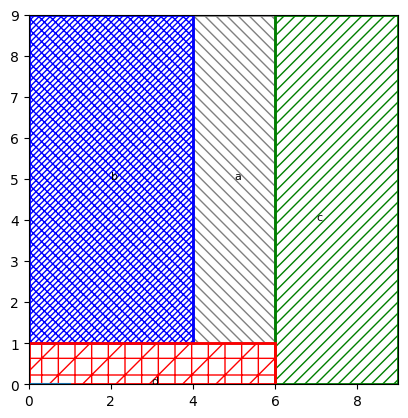

slicing_floorplan runtime : 0.0779578685760498
slicing_floorplan area : 81.0 Utilization : 100.0
[((0.0, 0.0), (4.0, 8.0), 'b'), ((4.0, 0.0), (2.0, 8.0), 'a'), ((0.0, 8.0), (6.0, 1.0), 'd'), ((6.0, 0.0), (3.0, 9.0), 'c')]


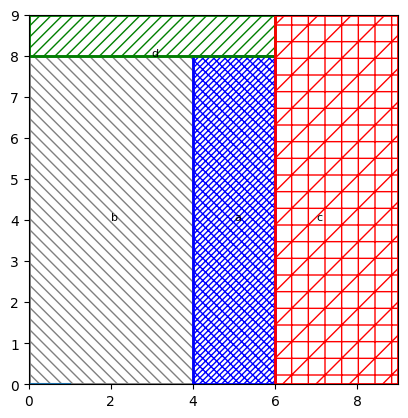

sp_floorplan runtime : 0.14891600608825684
sp_floorplan area : 81.0 Utilization : 100.0
[((0, 8.0), (6.0, 1.0), 'd'), ((0, 0), (4.0, 8.0), 'b'), ((6.0, 0), (3.0, 9.0), 'c'), ((4.0, 0), (2.0, 8.0), 'a')]


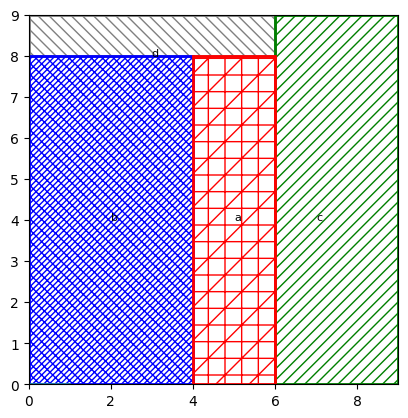

In [12]:
import time
m = [Module('a', 16, [0.25, 4]), Module('b', 32, [2.0, 0.5]), Module('c', 27, [1./3, 3.]), Module('d', 6, [6])]
sumarea = sum([i._area for i in m])
for fpfn in [ilp_floorplan, slicing_floorplan, sp_floorplan]:
  t = time.time()
  sol, area = fpfn(m)
  print(f"{fpfn.__name__} runtime :", time.time() - t)
  if sol:
    print(f"{fpfn.__name__} area :", area, "Utilization :", sumarea * 100./area)
    plot(sol)

ilp_floorplan runtime : 18.88899326324463
ilp_floorplan area : 429.13468168596177 Utilization : 93.44385739800202
[((0.0, 1.3903794608950548), (7.0710678118654755, 7.0710678118654755), '0'), ((7.0710678118654755, 0.3374089938818301), (8.12403840463596, 8.12403840463596), '1'), ((9.575779326414704, 9.539392014169465), (7.810249675906654, 7.810249675906654), '2'), ((15.195106216501436, 0.0), (9.539392014169456, 9.539392014169456), '3'), ((17.386029002321358, 9.53939201416945), (7.3484692283495345, 7.3484692283495345), '4'), ((0.0, 8.46144727276053), (8.888194417315589, 8.888194417315589), '5')]


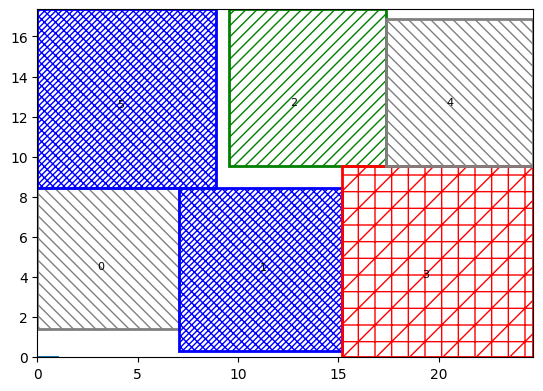

slicing_floorplan runtime : 0.06189727783203125
slicing_floorplan area : 450.3937050005995 Utilization : 89.03321595035753
[((0.0, 0.0), (7.810249675906654, 7.810249675906654), '2'), ((7.810249675906654, 0.0), (7.3484692283495345, 7.3484692283495345), '4'), ((15.158718904256189, 0.0), (8.12403840463596, 8.12403840463596), '1'), ((0.0, 8.12403840463596), (7.0710678118654755, 7.0710678118654755), '0'), ((7.0710678118654755, 8.12403840463596), (9.539392014169456, 9.539392014169456), '3'), ((16.610459826034933, 8.12403840463596), (8.888194417315589, 8.888194417315589), '5')]


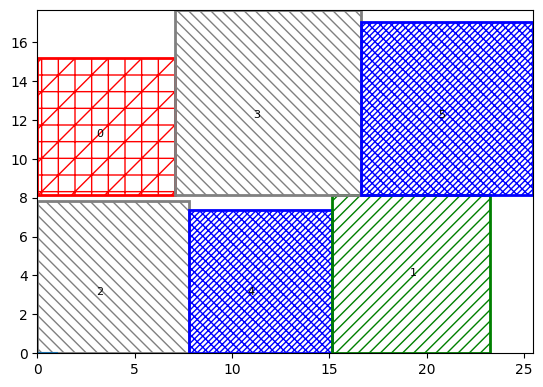

sp_floorplan runtime : 0.3761012554168701
sp_floorplan area : 431.35350306540556 Utilization : 92.96319541867658
[((0, 17.01223282195155), (7.3484692283495345, 7.3484692283495345), '4'), ((8.888194417315589, 7.810249675906654), (7.0710678118654755, 7.0710678118654755), '0'), ((0, 0), (8.888194417315589, 8.888194417315589), '5'), ((8.888194417315589, 0), (7.810249675906654, 7.810249675906654), '2'), ((8.12403840463596, 14.88131748777213), (9.539392014169456, 9.539392014169456), '3'), ((0, 8.888194417315589), (8.12403840463596, 8.12403840463596), '1')]


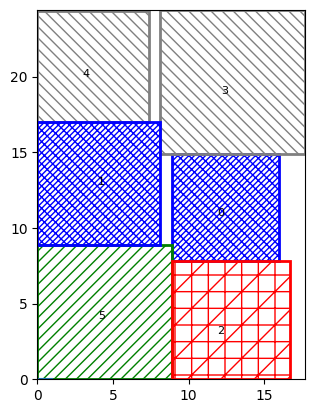

In [13]:
m = [Module(str(i), random.randint(10,100), [1.]) for i in range(6)]
sumarea = sum([i._area for i in m])
for fpfn in [ilp_floorplan, slicing_floorplan, sp_floorplan]:
  t = time.time()
  sol, area = fpfn(m)
  print(f"{fpfn.__name__} runtime :", time.time() - t)
  if sol:
    print(f"{fpfn.__name__} area :", area, "Utilization :", sumarea * 100./area)
    plot(sol)